In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn import preprocessing

In the below block, we give unique userID-s to our users. For the sake of convinience we have not kept the names of our users, instead we generated unique ID-s using perfect hashing function that generates an integer combining user wieght and age(By the way we do not have any user that have the same age and weight, thus collisions are impossible).

In [2]:
dfs = pd.read_excel('UpdatedData.xlsx', sheet_name='Data')
dfs['UserID'] = pd.factorize(((dfs.weight+dfs.age)*(dfs.weight+dfs.age + 1)/2) + dfs.age)[0]
dfs.to_csv('lavData.csv')

# Data Manipulation Part

In [3]:
data = pd.read_csv('lavData.csv')
data = data.drop('Unnamed: 0',axis=1)
data = data.drop(data.index[len(data)-1])
pd.set_option('display.max_columns', None)
data["gender"]=data["gender"].astype("category").cat.codes
data = data.loc[data['time_period'] == 2.0]
data = data.drop('time_period',axis=1)
data = data.drop('yesterday',axis=1)
data = data.drop('UserID',axis = 1)
data = data.drop('Diet. Type',axis=1)


data.head(15)

,cheat,weight,gender,age,water_balance,walking,digestion,motivation,hunger,anxiety,result_perception,sugar,artificial sweetener,fiber (grams),protein,carbs,fats,fast_carbs,physical_activity,fatigue,sleep,craving,calorie_deficit,meal_number
0,1,75.0,0,48,1.5,4.4,0,8,1,2,1,1,0,17,40,55,5,20,2,5,6,4,30,3
1,1,56.0,0,27,1.7,6.3,0,2,4,2,2,0,0,22,40,35,25,15,3,2,7,5,25,4
2,0,69.0,0,23,2.5,6.2,1,1,1,2,3,1,1,15,40,55,5,20,2,4,7,1,20,4
3,1,73.0,0,41,1.2,7.0,0,7,1,8,3,0,1,23,35,45,20,25,4,4,6,3,20,4
4,1,61.0,0,24,1.3,5.1,1,3,2,6,5,1,1,21,35,55,10,25,4,4,8,2,30,5
5,1,75.0,0,22,2.4,7.6,1,8,2,7,1,0,1,24,35,35,30,15,3,5,6,5,15,5
6,1,70.0,0,37,1.4,6.6,1,6,4,5,5,0,1,11,40,50,10,20,2,3,6,1,35,5
7,1,76.0,0,48,1.0,8.0,0,9,3,4,4,1,0,17,25,50,25,20,3,3,6,5,35,5
8,0,65.0,0,18,2.1,3.5,1,2,3,5,3,1,1,13,45,45,10,25,1,1,8,1,30,5
9,0,57.0,0,40,1.4,5.9,1,6,5,9,1,0,0,11,40,35,25,20,5,5,8,3,15,5


In [4]:
data.cheat.value_counts()

0    208
1    162
Name: cheat, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 369
Data columns (total 24 columns):
cheat                   370 non-null int64
weight                  370 non-null float64
gender                  370 non-null int8
age                     370 non-null int64
water_balance           370 non-null float64
walking                 370 non-null float64
digestion               370 non-null int64
motivation              370 non-null int64
hunger                  370 non-null int64
anxiety                 370 non-null int64
result_perception       370 non-null int64
sugar                   370 non-null int64
artificial sweetener    370 non-null int64
fiber (grams)           370 non-null int64
protein                 370 non-null int64
carbs                   370 non-null int64
fats                    370 non-null int64
fast_carbs              370 non-null int64
physical_activity       370 non-null int64
fatigue                 370 non-null int64
sleep                   370 no

In [6]:
tbl = pd.crosstab(index=data["meal_number"],columns="count")     
tbl 

col_0,count
meal_number,
3,81
4,161
5,128


In [7]:
tbl1 = pd.crosstab(index=data["physical_activity"],columns="count")     
tbl1 

col_0,count
physical_activity,
1,75
2,84
3,89
4,51
5,71


In [8]:
tbl2 = pd.crosstab(index=data["hunger"],columns="count")     
tbl2 

col_0,count
hunger,
1,78
2,93
3,67
4,68
5,64


As you can notic with above 3 blocks of code we tried to detect whether there is a column in our data that has a value with majority count so that we will be able to binarize that column, that is, label whether the row contains the majority value or not.

In [9]:
data.head(15)

,cheat,weight,gender,age,water_balance,walking,digestion,motivation,hunger,anxiety,result_perception,sugar,artificial sweetener,fiber (grams),protein,carbs,fats,fast_carbs,physical_activity,fatigue,sleep,craving,calorie_deficit,meal_number
0,1,75.0,0,48,1.5,4.4,0,8,1,2,1,1,0,17,40,55,5,20,2,5,6,4,30,3
1,1,56.0,0,27,1.7,6.3,0,2,4,2,2,0,0,22,40,35,25,15,3,2,7,5,25,4
2,0,69.0,0,23,2.5,6.2,1,1,1,2,3,1,1,15,40,55,5,20,2,4,7,1,20,4
3,1,73.0,0,41,1.2,7.0,0,7,1,8,3,0,1,23,35,45,20,25,4,4,6,3,20,4
4,1,61.0,0,24,1.3,5.1,1,3,2,6,5,1,1,21,35,55,10,25,4,4,8,2,30,5
5,1,75.0,0,22,2.4,7.6,1,8,2,7,1,0,1,24,35,35,30,15,3,5,6,5,15,5
6,1,70.0,0,37,1.4,6.6,1,6,4,5,5,0,1,11,40,50,10,20,2,3,6,1,35,5
7,1,76.0,0,48,1.0,8.0,0,9,3,4,4,1,0,17,25,50,25,20,3,3,6,5,35,5
8,0,65.0,0,18,2.1,3.5,1,2,3,5,3,1,1,13,45,45,10,25,1,1,8,1,30,5
9,0,57.0,0,40,1.4,5.9,1,6,5,9,1,0,0,11,40,35,25,20,5,5,8,3,15,5


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 369
Data columns (total 24 columns):
cheat                   370 non-null int64
weight                  370 non-null float64
gender                  370 non-null int8
age                     370 non-null int64
water_balance           370 non-null float64
walking                 370 non-null float64
digestion               370 non-null int64
motivation              370 non-null int64
hunger                  370 non-null int64
anxiety                 370 non-null int64
result_perception       370 non-null int64
sugar                   370 non-null int64
artificial sweetener    370 non-null int64
fiber (grams)           370 non-null int64
protein                 370 non-null int64
carbs                   370 non-null int64
fats                    370 non-null int64
fast_carbs              370 non-null int64
physical_activity       370 non-null int64
fatigue                 370 non-null int64
sleep                   370 no

# Training Part

In [11]:
data.cheat.value_counts()/len(data)*100

0    56.216216
1    43.783784
Name: cheat, dtype: float64

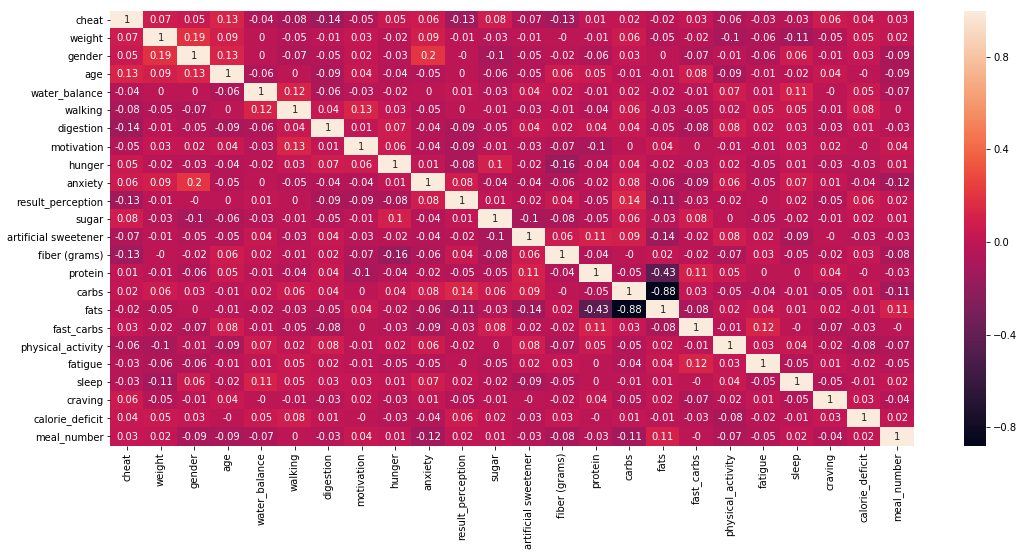

In [12]:
plt.figure(figsize=(18,8))
sns.heatmap(round(data.corr(),2),annot=True)
plt.show()

In [13]:
pd.DataFrame(data.corr())

,cheat,weight,gender,age,water_balance,walking,digestion,motivation,hunger,anxiety,result_perception,sugar,artificial sweetener,fiber (grams),protein,carbs,fats,fast_carbs,physical_activity,fatigue,sleep,craving,calorie_deficit,meal_number
cheat,1.000000,0.066100,0.053399,0.129474,-0.044961,-0.076302,-0.143519,-0.050643,0.047618,0.061712,-0.131282,0.081246,-0.072861,-0.127442,0.008254,0.019748,-0.021737,0.026638,-0.062916,-0.028676,-0.031858,0.060643,0.038076,0.032517
weight,0.066100,1.000000,0.194021,0.093709,0.000972,-0.047267,-0.010181,0.027550,-0.015299,0.086772,-0.012784,-0.025394,-0.013710,-0.000094,-0.009303,0.064843,-0.054039,-0.021359,-0.101625,-0.056323,-0.114664,-0.045974,0.050638,0.019694
gender,0.053399,0.194021,1.000000,0.129832,0.003396,-0.069799,-0.053399,0.015002,-0.034431,0.195271,-0.003691,-0.097824,-0.049335,-0.018817,-0.061946,0.027568,0.004638,-0.065556,-0.006301,-0.064636,0.064505,-0.013380,0.032773,-0.089798
age,0.129474,0.093709,0.129832,1.000000,-0.057088,0.002674,-0.089266,0.043955,-0.036154,-0.052298,0.004504,-0.056056,-0.048905,0.064037,0.049177,-0.013541,-0.011206,0.084118,-0.092672,-0.006138,-0.018755,0.044039,-0.001944,-0.086386
water_balance,-0.044961,0.000972,0.003396,-0.057088,1.000000,0.117942,-0.059195,-0.034191,-0.017700,0.000926,0.013379,-0.031150,0.041194,0.015110,-0.009444,0.022665,-0.015940,-0.007474,0.072633,0.009063,0.110719,-0.000941,0.048082,-0.071119
walking,-0.076302,-0.047267,-0.069799,0.002674,0.117942,1.000000,0.040880,0.125795,0.032628,-0.050081,0.003447,-0.014381,-0.026626,-0.005421,-0.042657,0.060259,-0.034024,-0.053225,0.015273,0.050912,0.046599,-0.014975,0.078231,0.004975
digestion,-0.143519,-0.010181,-0.053399,-0.089266,-0.059195,0.040880,1.000000,0.006377,0.065523,-0.040049,-0.092597,-0.048452,0.040171,0.016292,0.036166,0.035961,-0.049647,-0.080203,0.082518,0.020489,0.031858,-0.032586,0.007272,-0.025163
motivation,-0.050643,0.027550,0.015002,0.043955,-0.034191,0.125795,0.006377,1.000000,0.058760,-0.037714,-0.085289,-0.006939,-0.033377,-0.071228,-0.099580,0.004956,0.042948,0.002912,-0.009735,-0.007268,0.030906,0.023966,-0.000122,0.043979
hunger,0.047618,-0.015299,-0.034431,-0.036154,-0.017700,0.032628,0.065523,0.058760,1.000000,0.010568,-0.082960,0.099617,-0.022958,-0.163626,-0.040975,0.043548,-0.019757,-0.025770,0.015499,-0.054843,0.012350,-0.034187,-0.031669,0.012366
anxiety,0.061712,0.086772,0.195271,-0.052298,0.000926,-0.050081,-0.040049,-0.037714,0.010568,1.000000,0.083326,-0.044474,-0.042300,-0.059507,-0.020073,0.078234,-0.060986,-0.091042,0.055250,-0.048238,0.065994,0.011477,-0.039354,-0.117642


In [14]:
y = data.cheat.apply(int)
x = data.drop(["cheat"],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.35,random_state=42)

In [15]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# GradientBoostingClassifier

In [16]:
parameters = {'loss': ['deviance', 'exponential'], 
              'learning_rate': np.arange(0.1, 1, 0.2), 
              'max_depth': np.arange(3, 10),
              'max_features': ['auto', 'sqrt', 'log2', None],
              'min_samples_leaf':[i for i in range(1,10)]}
rsearch = RandomizedSearchCV(GradientBoostingClassifier(), parameters, scoring='roc_auc', cv=5)
rsearch.fit(x_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'loss': ['deviance', 'exponential'], 'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9]), 'max_depth': array([3, 4, 5, 6, 7, 8, 9]), 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=0)

In [17]:
report(rsearch.cv_results_)

Model with rank: 1
Mean validation score: 0.587 (std: 0.080)
Parameters: {'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 9, 'loss': 'deviance', 'learning_rate': 0.1}

Model with rank: 2
Mean validation score: 0.586 (std: 0.080)
Parameters: {'min_samples_leaf': 5, 'max_features': None, 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.9000000000000001}

Model with rank: 3
Mean validation score: 0.584 (std: 0.073)
Parameters: {'min_samples_leaf': 7, 'max_features': 'auto', 'max_depth': 7, 'loss': 'exponential', 'learning_rate': 0.1}



In [18]:
xgbtree = rsearch.best_estimator_
xgbtree.fit(x_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=6, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [19]:
y_pred = xgbtree.predict(x_test)

In [20]:
cm = confusion_matrix(y_pred,y_test)

In [21]:
cm

array([[44, 31],
       [32, 23]])

In [22]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.58666667, 0.41818182]),
 array([0.57894737, 0.42592593]),
 array([0.58278146, 0.42201835]),
 array([76, 54]))

In [23]:
print('Accuracy is',xgbtree.score(x_train,y_train)*100) 

Accuracy is 100.0


In [24]:
print('Accuracy is',xgbtree.score(x_test,y_test)*100) 

Accuracy is 51.53846153846153


In [25]:
print('Cross validation score',np.mean(cross_val_score(xgbtree, x_test, y_test, cv=5))*100)


Cross validation score 62.350997150997145


In [26]:
pred = xgbtree.predict(x_test)
tmp = roc_auc_score(y_test, pred)*100
print('Roc Auc Score is', tmp)
cm = confusion_matrix(y_test, pred) 
print(cm)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print("Accuracy is",accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity is ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity is ', specificity)


Roc Auc Score is 50.243664717348935
[[44 32]
 [31 23]]
Accuracy is 0.5153846153846153
Sensitivity is  0.5789473684210527
Specificity is  0.42592592592592593


# With Logistic Regression

In [27]:
model_logit = LogisticRegression(random_state=42)
model_logit.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
print("Accuracy on train",model_logit.score(x_train, y_train)*100)

Accuracy on train 63.74999999999999


In [29]:
print("Accuracy on test",model_logit.score(x_test, y_test)*100)

Accuracy on test 57.692307692307686


In [30]:
y_pred = model_logit.predict(x_test)

In [31]:
cm = confusion_matrix(y_pred,y_test)

In [32]:
cm

array([[44, 23],
       [32, 31]])

In [33]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.65671642, 0.49206349]),
 array([0.57894737, 0.57407407]),
 array([0.61538462, 0.52991453]),
 array([76, 54]))

In [34]:
print('Cross validation score',np.mean(cross_val_score(model_logit, x_test, y_test, cv=5))*100)


Cross validation score 62.14017094017093


In [35]:
pred = model_logit.predict(x_test)
tmp = roc_auc_score(y_test, pred)*100
print('Roc Auc Score is', tmp)
cm = confusion_matrix(y_test, pred) 
print(cm)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print("Accuracy is",accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity is ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity is ', specificity)


Roc Auc Score is 57.65107212475633
[[44 32]
 [23 31]]
Accuracy is 0.5769230769230769
Sensitivity is  0.5789473684210527
Specificity is  0.5740740740740741


# Now let's try with Naive Bayes classifier and compare the results

In [36]:
from sklearn.naive_bayes import GaussianNB

In [37]:
gnb = GaussianNB()

In [38]:
gnb.fit(x_train, y_train)

GaussianNB(priors=None)

In [39]:
print('Accuracy on train set',gnb.score(x_train,y_train)*100)

Accuracy on train set 65.41666666666667


In [40]:
print('Accuracy on test set',gnb.score(x_test,y_test)*100)

Accuracy on test set 56.15384615384615


In [41]:
y_pred = gnb.predict(x_test)

In [42]:
cm = confusion_matrix(y_pred,y_test)

In [43]:
cm

array([[42, 23],
       [34, 31]])

In [44]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.64615385, 0.47692308]),
 array([0.55263158, 0.57407407]),
 array([0.59574468, 0.5210084 ]),
 array([76, 54]))

In [45]:
print('Cross validation score',np.mean(cross_val_score(gnb, x_test, y_test, cv=5))*100)

Cross validation score 62.852421652421654


In [46]:
pred = gnb.predict(x_test)
tmp = roc_auc_score(y_test, pred)*100
print('Roc Auc Score is', tmp)
cm = confusion_matrix(y_test, pred) 
print(cm)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print("Accuracy is",accuracy)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity is ', sensitivity )
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity is ', specificity)


Roc Auc Score is 56.33528265107211
[[42 34]
 [23 31]]
Accuracy is 0.5615384615384615
Sensitivity is  0.5526315789473685
Specificity is  0.5740740740740741


# Diet generation 

In [47]:
w = input('Please enter you wight = ')
g = input('Please enter you gender (either 1 or 0) = ')
a = input('Please enter you age = ')
s = input('Please enter you sleep = ')
m = input('Pleas enter your motivation level ranging from 1 to 10 = ')

Please enter you wight = 95
Please enter you gender (either 1 or 0) = 1
Please enter you age = 20
Please enter you sleep = 7
Pleas enter your motivation level ranging from 1 to 10 = 7


Here we generate some normative values for our columns except the ones that users give us or are the part of diet program. 

In [48]:
def user_data_generator(motivation,weight,gender,age,sleep, protein, carbs, fats):
    
    columns = ['weight','gender','age', 'water_balance', 'walking','digestion',
               'motivation','hunger','anxiety','result_perception', 'sugar', 
               'artificial sweetener', 'fiber', 'protein', 'carbs', 'fats', 
               'fats_carbs', 'fatigue','physical_activity',
               'sleep', 'craving', 'calorie_deficit', 'meal_number']
    
    df = pd.DataFrame(columns=columns)
    
    
    def getRandAnsw():
        descisionMaker = random.randint(1, 10)
        descisionMakerString = 1
    
        if descisionMaker % 2 == 0:
            descisionMakerString = 1
        else:
            descisionMakerString = 0
    
        return descisionMakerString
    
    def getRandCraving():
        tiv = random.randint(1, 4)
        answer = 'nan'
        if tiv == 1:
            answer = 'sugary'
        elif tiv == 2:
            answer = 'savory'
        elif tiv == 3:
            answer = 'crunchy'
        else:
            answer = 'other'
    
        return answer
    
    
    
    
   
     
    df = df.append({'weight': weight,
                    'gender': gender,
                    'age': age,
                    'water_balance': random.randint(2,5),
                    'walking': random.randint(4, 15),
                    'digestion': getRandAnsw(),
                    'motivation': motivation,
                    'hunger': random.randint(1, 5),
                    'anxiety': random.randint(0, 10),
                    'result_perception': random.randint(1, 5),
                    'sugar': getRandAnsw(),
                    'artificial sweetener': getRandAnsw(),
                    'fiber': random.randint(1, 10),
                    'protein': protein,
                    'carbs': carbs,
                    'fats': fats,
                    'fats_carbs': random.randint(15, 25),
                    'physical_activity': random.randint(1, 5),
                    'fatigue': random.randint(1, 5),
                    'sleep': sleep,
                    'craving': random.randint(1, 4),
                    'calorie_deficit': random.randint(1, 10),
                    'meal_number': random.randint(1, 5)
                    }, ignore_index=True)
    
    return df
    
    

In [49]:
diet1 = np.array([35, 45,15])
diet2 = np.array([40, 40,30])
diet3 = np.array([45, 40,15])
diet4 = np.array([0, 0,10])
diet5 = np.array([0, 35,0])

In [50]:
def give_best_diet(weight,gender,age,sleep, motivation, tree):
    v1 = user_data_generator(motivation, weight, gender, age, sleep, diet1[0],diet1[1],diet1[2])
    v2 = user_data_generator(motivation, weight, gender, age, sleep, diet2[0],diet2[1],diet2[2])
    v3 = user_data_generator(motivation, weight, gender, age, sleep, diet3[0],diet3[1],diet3[2])
    v4 = user_data_generator(motivation, weight, gender, age, sleep, diet4[0],diet4[1],diet4[2])
    v5 = user_data_generator(motivation, weight, gender, age, sleep, diet5[0],diet5[1],diet5[2])
    
    val1 = tree.predict_proba(v2)
    
    val2 = tree.predict_proba(v2)
    val3 = tree.predict_proba(v2)
    val4 = tree.predict_proba(v2)
    val5 = tree.predict_proba(v2)
    
   
    
    result = np.amax([val1[0][0],val2[0][0],val3[0][0],val4[0][0],val5[0][0]])
    
   
    
    if result == val1[0][0]:
        return v1
    elif result == val2[0][0]:
        return v2
    elif result == val3[0][0]:
        return v3
    elif result == val4[0][0]:
        return v4
    else:
        return v5
    
    

In the above block of code we compute the probabilities of non-cheating for each type of diet and pick the diet with the largest one. In the ideal case we should carefully compute other column values such as calorie_deficit, meal_number and etc., however, in this project we tried to represent how historical data can be used to give our user best diet, thus, we did not give much importance to the rest metrics and tried to interprete the general process.

In [51]:
give_best_diet(w,g,a,s,m,xgbtree)

,weight,gender,age,water_balance,walking,digestion,motivation,hunger,anxiety,result_perception,sugar,artificial sweetener,fiber,protein,carbs,fats,fats_carbs,fatigue,physical_activity,sleep,craving,calorie_deficit,meal_number
0,95,1,20,3,13,0,7,3,3,1,0,1,2,35,45,15,16,5,3,7,2,5,1


Derived row can be later used to show human readable diet plan to the user of the app.

In [52]:
give_best_diet(w,g,a,s,m,model_logit)

,weight,gender,age,water_balance,walking,digestion,motivation,hunger,anxiety,result_perception,sugar,artificial sweetener,fiber,protein,carbs,fats,fats_carbs,fatigue,physical_activity,sleep,craving,calorie_deficit,meal_number
0,95,1,20,5,6,0,7,1,2,3,0,1,3,35,45,15,20,2,2,7,4,7,1


In [53]:
give_best_diet(w,g,a,s,m,gnb)

,weight,gender,age,water_balance,walking,digestion,motivation,hunger,anxiety,result_perception,sugar,artificial sweetener,fiber,protein,carbs,fats,fats_carbs,fatigue,physical_activity,sleep,craving,calorie_deficit,meal_number
0,95,1,20,2,10,1,7,3,10,5,0,0,4,35,45,15,20,1,4,7,3,6,4
